# Development of Matrix Wiener Filter

In [1]:
using Polynomials
using LinearAlgebra
using DSP
using Plots
using FFTW
pyplot()

include("SFbyCKMS_Matrix.jl")

Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

In [2]:
function z_crossspect_fft(X,Y,L = 50, Nex = 2^10; win = "Par")
    ## Y = d x 1 x steps, X = nu x 1 x steps
    d, stepsx = size(X)
    nu, stepsy = size(Y)

    Nexh = Int(floor(Nex/2))
    lags = -L:L;

    stepsx == stepsy || print("X and Y are not the same length. Taking min.")
    steps = minimum([stepsx stepsy])

    # Smoothed viewing window
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end
    Lam = [lam[L+1:-1:2]; lam]

    C_smoothed = zeros(d,nu,length(lags))
    for i = 1 : d
        for j = 1 : nu
            C_smoothed[i,j,:] = Lam .* crosscov(X[i,1:steps],Y[j,1:steps],lags)
        end
    end

    ## C_smoothed = d x nu x 2L+1

    ## Pad with zeros in preparation for fft
    C_padded = cat(dims = 3, zeros(d,nu,Nex - Nexh - L), C_smoothed, zeros(d,nu,Nexh - L - 1))
    C = fftshift(C_padded,3)

    z_crossspect_num_fft = fft(C,3);
end

function Matrix_CKMS_c(P)
    d = size(P)[1];
    m = size(P)[3] - 1

    NN = reverse(P[:,:,2:end],dims = 3)
    Re = Rr = p0 = P[:,:,1]

    F = [[zeros(d,d*(m-1)); I] zeros(d*m,d)]
    h = [zeros(d,d*(m-1)) I]

    K = zeros(d*m,d)
    for i = 0 : m-1
        K[d*i + 1: d*(i+1),:] = NN[:,:,i+1]
    end
    L = K

    for i = 1:200
        hL = h*L
        FL = F*L

        K_new = K - FL/Rr*hL'
        L_new = FL - K/Re*hL
        Re_new = Re - hL/Rr*hL'
        Rr_new = Rr - hL'/Re*hL

        K = K_new
        L = L_new
        Re = Re_new
        Rr = Rr_new
    end

    k = K/Re
    re = Re

    sqrt_re = sqrt(re)
    
    l = complex(zeros(d,d,m+1))
    l[:,:,1] = sqrt_re;
    for i = m-1:-1:0
        l[:,:,m-i+1] = k[d*i + 1: d*(i+1),:]*sqrt_re
    end
    l    
end

function vector_wiener_filter_fft(pred, sig, M_out = 20; par::Int64 = 55, Nex::Int64 = 2^10, win = "Par")
    d, stepsy = size(sig)
    nu, stepsx = size(pred)

    stepsx == stepsy || print("X and Y are not the same length. Taking min.")
    steps = minimum([stepsx stepsy])

    Nexh = Int(floor(Nex/2))

    L = par
    lags = 0:L;

    # Smoothed viewing window
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end

    R_pred_smoothed = zeros(d,d,length(lags))
    for i = 1 : d
        for j = 1 : d
            R_pred_smoothed[i,j,:] = lam .* crosscov(pred[i,1:steps],pred[j,1:steps],lags)
        end
    end

    # Compute coefficients of spectral factorization of z-spect-pred
    l = Matrix_CKMS_c(R_pred_smoothed);

    l_pad_minus = cat(dims = 3,l,zeros(d,d,Nex - L - 1))

    z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
    z_spect_pred_plus_num_fft =complex(zeros(d,d,Nex))
    for i = 1 : Nex
        z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
    end

    # Compute z-cross-spectrum of sigpred
    z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred, par, Nex, win = "Par");

    # This computes the impule response (coefficeints of z) for S_{yx}{S_x^+}^{-1}
    S_sigpred_overS_plus_fft_num = complex(zeros(d,nu,Nex))
    for i = 1: Nex
        S_sigpred_overS_plus_fft_num[:,:,i] = z_crossspect_sigpred_num_fft[:,:,i]/z_spect_pred_plus_num_fft[:,:,i]
    end

    S_sigpred_overS_plus_fft_num_fft = ifft(S_sigpred_overS_plus_fft_num,3)

    # Extracts causal part coefficinets of S_{yx}{S_x^+}^{-1}, {S_{yx}{S_x^+}^{-1}}_+
    S_sigpred_overS_plus_fft_plus_num_fft = cat(dims = 3,S_sigpred_overS_plus_fft_num_fft[:,:,1: Nexh], zeros(d,nu,Nex - Nexh))

    # Computes causal part of S_{yx}/S_x^+, {S_{yx}/S_x^+}_+
    S_sigpred_overS_plus_plus_num_fft = fft(S_sigpred_overS_plus_fft_plus_num_fft,3);

    # Obtain transfer function H by dividing {S_{yx}/S_x^+}_+ by S_x^-

    H_num = complex(zeros(d,nu,Nex))
    for i = 1: Nex
        H_num[:,:,i] = S_sigpred_overS_plus_plus_num_fft[:,:,i]/z_spect_pred_minus_num_fft[:,:,i]
    end

    # Extrct tranferfunction coeffifcients (impulse responce of Weiner filter)
    h_num_raw = ifft(H_num,3)

    # Truncate
    h_num_fft = h_num_raw[:,:,1:M_out]
end

function Crosscov(X,Y,lags = 0:50)
    d, stepsx = size(X)
    nu, stepsy = size(Y)

    if stepsx != stepsy
        print("X and Y are not the same length. Taking min.")
    end

    steps = minimum([stepsx stepsy])

    C = zeros(d,nu,length(lags))
    for i = 1:d
        for j = 1:nu
            C[i,j,:] = crosscov(X[i,1:steps],Y[j,1:steps],lags)
        end
    end
    C
end

Crosscov (generic function with 2 methods)

### Generate Time series

Start with AR(1) process.

In [31]:
# p = 1
# c = [-1 2;.9 8]/9
# # Test for stability and stationarity
# all(abs.(eigvals(c)) .< 1) || error("matrix coefficent genarates unstable VAR process");

# sig_v = [1 0; 0 1];


# steps = 1*10^6
# discard = 10^3
# steps_tot = steps + discard

# noise_sig = randn(2,steps_tot)
# sig = zeros(2,steps_tot);

# sig[:,1:2] = noise_sig[:,1:2]

# for i = p+1 : steps_tot
#     sig[:,i] = c*sig[:,i-p] + noise_sig[:,i]
# end

# sig = sig[:,discard + 1 : steps_tot];

# noise_pred = sig_v*randn(2,steps)
# pred = sig .+ noise_pred;

VMA(1) diangonal process

In [14]:
r = [.4]
C = diagm(r)

sig_v = [3, 2]
Sig_v = diagm(sig_v)

2×2 Array{Int64,2}:
 3  0
 0  2

In [ ]:
p = 1

steps = 1*10^5
discard = 10^4
steps_tot = steps + discard

noise_sig = randn(1,steps_tot)
sig = zeros(1,steps_tot);

sig[:,1:p] = noise_sig[:,1:p] 

for i = p+1 : steps_tot
    sig[:,i] = noise_sig[:,i] - C * noise_sig[:,i-1]
end

sig = sig[:,discard + 1 : steps_tot];

M = [3;-1]
noise_pred = Sig_v*randn(2,steps)
pred = zeros(2,steps)
for i = 1:steps
    pred[:,i] = M * sig[i] .+ noise_pred[:,i]
end

2×100000 Array{Float64,2}:
  3.7052    0.940014  -3.0953   -11.0896   …  -0.77228   3.73857  12.622  
 -2.59442  -0.209353   2.11324   -1.95747      1.00006  -1.80482  -2.57892

In [33]:
### Analytic solution

rho_poly = [Poly([1, -(1 + r[i]^2 + sig_v[i]^2)/r[i], 1]) for i = 1:2]
rhos = [roots(poly) for poly in rho_poly]
rho = [rh[ abs.(rh) .< 1][1] for rh in rhos]
d = [rho[i]*((1+r[i]^2)/r[i] - rho[i]) for i=1:2]

M_h = 20
h_ana = zeros(2,2,M_h)
for i = 1:2
    h_ana[i,i,:] = [d[i]; [rho[i].^n*(d[i]-1) for n = 1 : M_h - 1]]
end
h_ana

2×2×20 Array{Float64,3}:
[:, :, 1] =
 0.990117  0.0     
 0.0       0.737384

[:, :, 2] =
 -0.00390664   0.0      
  0.0         -0.0383152

[:, :, 3] =
 -0.00154431   0.0       
  0.0         -0.00559012

...

[:, :, 18] =
 -1.38903e-9   0.0        
  0.0         -1.61496e-15

[:, :, 19] =
 -5.4909e-10   0.0       
  0.0         -2.3562e-16

[:, :, 20] =
 -2.17058e-10   0.0        
  0.0          -3.43765e-17

# Develope Wiener filter

In [32]:
# function wiener_filter_fft(pred, sig, M_out = 100; par::Int64 = 55, Nex::Int64 = 2^10)

M_out = 20
par = 55
Nex = 2^10
win = "Par"

########
d, stepsy = size(sig)
nu, stepsx = size(pred)

stepsx == stepsy || print("X and Y are not the same length. Taking min.")
steps = minimum([stepsx stepsy])

Nexh = Int(floor(Nex/2))

L = par
lags = 0:L;

# Smoothed viewing window
if win == "Bar"
    lam = 1 .- (0:L)/L
elseif win == "Tuk"
    lam = .5*(1 .+ cos.(pi/L*(0:L)))
elseif win == "Par"
    LL = Int(floor(L/2))
    lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
    lam2 = 2*(1 .- (LL+1:L)/L).^3
    lam = [lam1; lam2]
else
    lam = ones(L+1)
end

R_pred_smoothed = zeros(nu,nu,length(lags))
for i = 1 : nu
    for j = 1 : nu
        R_pred_smoothed[i,j,:] = lam .* crosscov(pred[i,1:steps],pred[j,1:steps],lags)
    end
end

# Compute coefficients of spectral factorization of z-spect-pred
l = Matrix_CKMS_c(R_pred_smoothed);

l_pad_minus = cat(dims = 3,l,zeros(nu,nu,Nex - L - 1))

z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
z_spect_pred_plus_num_fft =complex(zeros(nu,nu,Nex))
for i = 1 : Nex
    z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
end


In [35]:
# ###### Veruiy z_spect_pred_minus_num_fft

# ## Analytical solution

# z_spect_pred_minus_ana(z) = diagm([sqrt(r[i]/rho[i])*(1 - rho[i]*z^(-1)) for i = 1:2])
# z_spect_pred_minus_ana_plot = complex(zeros(2,2,Nex))
# for i = 1:Nex
#     z_spect_pred_minus_ana_plot[:,:,i] = z_spect_pred_minus_ana(Z[i])
# end

# plot(Theta, real.([z_spect_pred_minus_ana_plot[1,1,:] z_spect_pred_minus_ana_plot[2,2,
#             :] z_spect_pred_minus_num_fft[1,1,:] z_spect_pred_minus_num_fft[1,2,
#             :] z_spect_pred_minus_num_fft[2,2,:]]),
#             line = (2,[:solid :solid :dash :dash :dash]),
#             color = [:red :red :black :black :black])

# ## Passed test

In [33]:
# Compute z-cross-spectrum of sigpred
z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred, par, Nex, win = "Par");

In [37]:
# ###### Veruiy z_crossspect_sigpred_num_fft

# ## Analytical solution

# z_crossspect_sigpred_ana(z) = diagm([(1 - r[i]*z^(-1))*(1 - r[i]*z) for i = 1:2])
# z_crossspect_sigpred_ana_plot = complex(zeros(2,2,Nex))
# for i = 1:Nex
#     z_crossspect_sigpred_ana_plot[:,:,i] = z_crossspect_sigpred_ana(Z[i])
# end

# plot(Theta, real.([z_crossspect_sigpred_ana_plot[1,1,:] z_crossspect_sigpred_ana_plot[2,2,
#             :] z_crossspect_sigpred_num_fft[1,1,:] z_crossspect_sigpred_num_fft[1,2,
#             :] z_crossspect_sigpred_num_fft[2,2,:]]),
#             line = (2,[:solid :solid :dash :dash :dash]),
#             color = [:red :red :black :black :black])

# ## Passed test

In [34]:
size(z_spect_pred_plus_num_fft)

(2, 2, 1024)

In [35]:
# This computes the impule response (coefficeints of z) for S_{yx}{S_x^+}^{-1}
S_sigpred_overS_plus_fft_num = complex(zeros(d,nu,Nex))
for i = 1: Nex
    S_sigpred_overS_plus_fft_num[:,:,i] = z_crossspect_sigpred_num_fft[:,:,i]/z_spect_pred_plus_num_fft[:,:,i]
end

In [36]:
S_sigpred_overS_plus_fft_num_fft = ifft(S_sigpred_overS_plus_fft_num,3)

# Extracts causal part coefficinets of S_{yx}{S_x^+}^{-1}, {S_{yx}{S_x^+}^{-1}}_+
S_sigpred_overS_plus_fft_plus_num_fft = cat(dims = 3,S_sigpred_overS_plus_fft_num_fft[:,:,1: Nexh], zeros(d,nu,Nex - Nexh))

# Computes causal part of S_{yx}/S_x^+, {S_{yx}/S_x^+}_+
S_sigpred_overS_plus_plus_num_fft = fft(S_sigpred_overS_plus_fft_plus_num_fft,3);

In [39]:
# ###### Veruiy S_sigpred_overS_plus_plus_num_fft

# ## Analytical solution

# S_sigpred_overS_plus_plus_ana(z) = diagm([-sqrt(rho[i]*r[i])*z^(-1) +
#         sqrt(rho[i]/r[i])*(1+r[i]^2) - rho[i]*sqrt(rho[i]*r[i]) for i = 1:2])

# S_sigpred_overS_plus_plus_ana_plot = complex(zeros(2,2,Nex))
# for i = 1:Nex
#     S_sigpred_overS_plus_plus_ana_plot[:,:,i] = S_sigpred_overS_plus_plus_ana(Z[i])
# end

# plot(Theta, real.([S_sigpred_overS_plus_plus_ana_plot[1,1,:] S_sigpred_overS_plus_plus_ana_plot[2,2,
#             :] S_sigpred_overS_plus_plus_num_fft[1,1,:] S_sigpred_overS_plus_plus_num_fft[1,2,
#             :] S_sigpred_overS_plus_plus_num_fft[2,2,:]]),
#             line = (2,[:solid :solid :dash :dash :dash]),
#             color = [:red :red :black :black :black])

# ## Passed test

In [37]:
# Obtain transfer function H by dividing {S_{yx}/S_x^+}_+ by S_x^-

H_num = complex(zeros(d,nu,Nex))
for i = 1: Nex
    H_num[:,:,i] = S_sigpred_overS_plus_plus_num_fft[:,:,i]/z_spect_pred_minus_num_fft[:,:,i]
end

# Extrct tranferfunction coeffifcients (impulse responce of Weiner filter)
h_num_raw = ifft(H_num,3)

# Truncate
h_num_fft = h_num_raw[:,:,1:M_out]
# end

1×2×20 Array{Complex{Float64},3}:
[:, :, 1] =
 0.152565+1.62128e-19im  -0.115716+6.26313e-20im

[:, :, 2] =
 -0.0245043+1.5468e-18im  0.0178035-3.02294e-19im

[:, :, 3] =
 -0.0041804-8.27137e-19im  0.00551273-4.43876e-19im

...

[:, :, 18] =
 -0.000119093-2.49543e-18im  0.000326697+2.43476e-18im

[:, :, 19] =
 0.000232753+8.95753e-19im  0.000114986+1.96708e-18im

[:, :, 20] =
 -0.000168865-2.02121e-18im  -0.000219272-7.12017e-19im

In [47]:
h_num_fft = vector_wiener_filter_fft(pred, sig, 20)

2×2×20 Array{Complex{Float64},3}:
[:, :, 1] =
   0.989859-7.4145e-19im   5.20007e-5-1.25902e-24im
 0.00409694+3.13173e-19im    0.736147-2.61902e-19im

[:, :, 2] =
   -0.0040963-2.34674e-18im  -3.31733e-5+8.82513e-21im
 -0.000557556+1.0314e-19im    -0.0384045+5.73023e-19im

[:, :, 3] =
 -0.00167752-9.07515e-19im  -4.58794e-5-1.25178e-20im
 0.000296783-9.37091e-20im  -0.00390835+2.47624e-18im

...

[:, :, 18] =
 -3.60364e-5-1.02504e-17im   -4.66452e-5-1.62757e-20im
  0.00158348-5.12681e-19im  -0.000186552-4.66232e-18im

[:, :, 19] =
 0.000133415-1.34827e-18im  8.65037e-6+1.68968e-20im
  0.00234143-7.70072e-19im  2.88502e-5+4.29804e-18im

[:, :, 20] =
 -0.000357262+2.98769e-19im  -3.38842e-5+1.42384e-20im
    -0.001896-6.83495e-19im    0.0006304+7.90848e-18im

Verify

In [39]:
sig_hat_num_fft = zeros(1,steps)
sig_hat_ana = zeros(1,steps)
for i = 1:steps
    sig_hat_num_fft[:,i] = sum([real.(h_num_fft[:,:,k+1])*pred[:,i-k] for k = 0:min(i - 1,M_out - 1)])
    #sig_hat_ana[:,i] = sum([real.(h_ana[:,:,k+1])*pred[:,i-k] for k = 0:min(i - 1,M_h - 1)])
end
sig_hat_ana = sig_hat_num_fft

1×100000 Array{Float64,2}:
 0.865497  0.0306551  -0.773321  -1.36598  …  -0.0876684  0.824358  2.10716

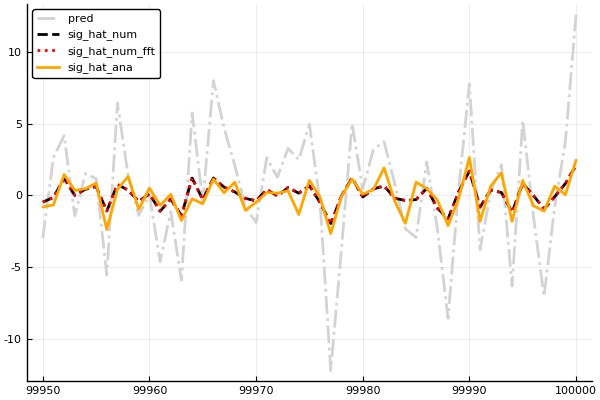

In [40]:
view = 50
start = steps - 50
tim = start:start + view;

plot(tim,[pred[1,tim] sig_hat_num_fft[1,tim] sig_hat_ana[1,tim] sig[1,tim]],
    color=[:lightgrey :black :red :orange], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

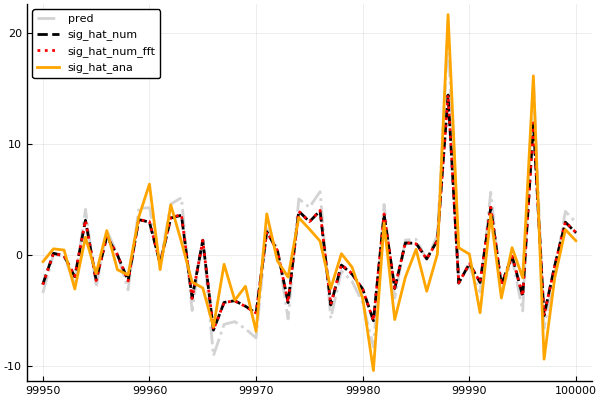

In [50]:
plot(tim,[pred[2,tim] sig_hat_num_fft[2,tim] sig_hat_ana[2,tim] sig[2,tim]],
    color=[:lightgrey :black :red :orange], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

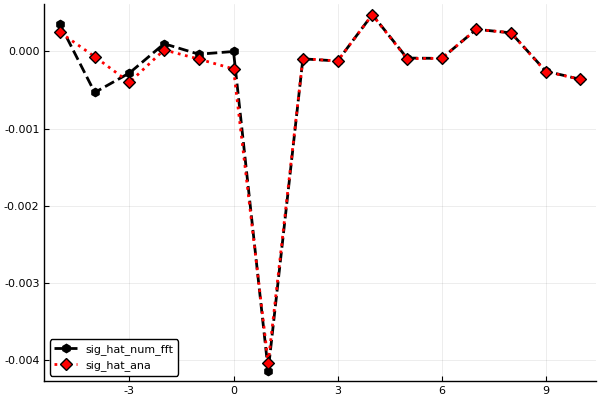

In [51]:
error_num_fft = sig .-sig_hat_num_fft
error_ana = sig .-sig_hat_ana

lags = -5:10
C_ana = Crosscov(error_ana,pred,lags)
C_num_fft = Crosscov(error_num_fft,pred,lags)

plot(lags, [C_num_fft[1,1,:] C_ana[1,1,:]],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))

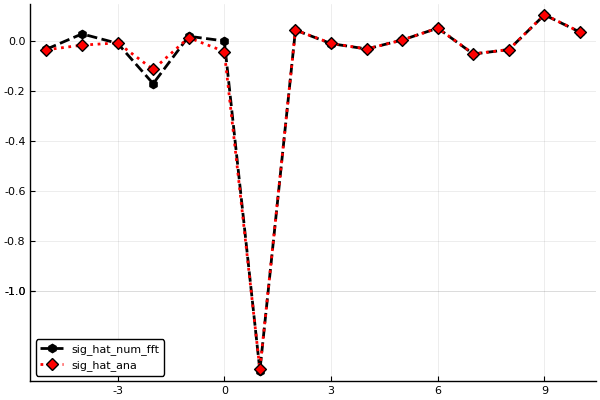

In [52]:
plot(lags, [C_num_fft[2,2,:] C_ana[2,2,:]],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))